In [1]:
from SocialNetwork.social_network_environment import *
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
#from SocialNetwork.cascade import *
from Advertising.learners.Greedy_algorithm import *
from Advertising.learners.UCB_no_anything import *
from Advertising.learners.UCB_no_qualities import *

seed = 6789 

arms = arms_creation(seed = 30291, number_of_arms= 20)

random.seed(seed)

exploration=4.2

deltas=[0.5,0.42,0.38,0.30,0.2,0.05]

social_network = social_network_environment()
social_network.init_from_json(json_path_network='Config/network.json', json_path_features='Config/features.json')

def create_adv_bids():
    adversary_bids = []
    for _ in range(0, 10): 
        adversary_i_bids = []
        for _ in range(0, 5):
            adversary_i_bids.append(random.randint(0, 4))
        adversary_bids.append(adversary_i_bids)
    return adversary_bids


n_rounds=20000


In [2]:
from Advertising.learners.UCB_sw import *

vcg = VCG()
rewards = [2.157131535448255, 1.057468991772039, 1.5243366983264601, 2.321893063583789]
clairvoyant = []

rolling_mean = []


ucb_nq_a = UCB_sw(arms = arms, hyperpar=exploration, window_size=2500)

for t in range(0, n_rounds):

    if t%5000 == 0:
        all_bids = create_adv_bids()
        rolling_mean.append(0)


    index=ucb_nq_a.pull_arm()
    best_arm = arms[index]


    all_bids.insert(0, best_arm)
    ad_allocation_list = setup(bids=all_bids, n_bids=5)
    best_allocation = vcg.all_best_allocations(ad_allocation_list, social_network)

    # Computing payments
    payments = vcg.payments(ad_allocation_list, best_allocation, social_network)

    total_reward, active_nodes = activate_cascade(social_network=social_network, ad_allocation_list=best_allocation, slot_prominence=deltas,learner_id=1)

    payments_tot = calculate_total_payment(payments, social_network.categories, active_nodes)


    reward = (total_reward-payments_tot)


    ucb_nq_a.update(index, reward)

    all_bids.pop(0)
    reset_nodes(social_network)

    if t<5000:
        clairvoyant.append(rewards[0])
    elif t<10000:
        clairvoyant.append(rewards[1])
    elif t<15000:
        clairvoyant.append(rewards[2])
    else:
        clairvoyant.append(rewards[3])

    rolling_mean.append((rolling_mean[-1]*t + reward)/(t+1))

print("Optimal arm, no qualities, all positions: "+str(arms[ucb_nq_a.return_best_arm()]))

Optimal arm, no qualities, all positions: [2, 3, 2, 1, 1]


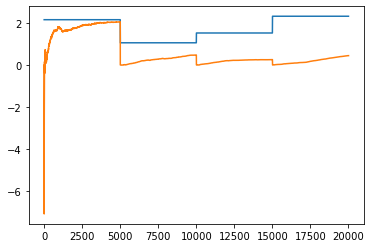

In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(clairvoyant)
plt.plot(rolling_mean)
plt.show()
